# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [2]:
import category_encoders as ce
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
df = pd.concat([train,test])
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [4]:
df.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [5]:
df.isnull().sum()

Inspection ID          0
DBA Name               0
AKA Name             845
License #              7
Facility Type        311
Risk                  19
Address                0
City                  71
State                 12
Zip                   34
Inspection Date        0
Inspection Type        1
Violations         12935
Latitude             259
Longitude            259
Location             259
Fail                   0
dtype: int64

In [6]:
df.drop(columns=['Inspection ID', 'License #', 'Latitude', 'Longitude', 'Location'], inplace=True)


In [7]:
df['no_violations'] = df['Violations'].isna()
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], infer_datetime_format=True)
df['Inspection Date'] = pd.Timestamp.today() - df['Inspection Date']
df['Inspection Date'] = df['Inspection Date'].dt.days

In [8]:
y_train = df['Fail']
X_train = df.drop(columns=['Fail'])


In [9]:
encoder = ce.BinaryEncoder(handle_unknown='ignore')
X_train = encoder.fit_transform(X_train)

X_train, X_val, y_train_y, y_val = train_test_split(X_train, y_train, 
                                                   test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label = y_train_y)
dval = xgb.DMatrix(X_val, label = y_val)

params = {
        'booster': 'dart',
        'learning_rate' : 0.1,
        'min_child_weight': 6,
        'max_depth' : 9,
        'gamma' : 0.2,
        'max_delta_step' : 0,
        'subsample' : 1,
        'colsample_bytree' : 0.9,
        'alpha' : 0,
        'scale_pos_weight' : 1,
        'eval_metric' : "auc",
        'n_jobs' : -1,   
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=420,
    evals=[(dtrain, 'Train'),(dval, 'Val')],
    early_stopping_rounds=42
)

print('Best AUC: {} in round {}'.format(model.best_score, model.best_iteration+1))

/Users/chrislouie/anaconda3/envs/data/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	Train-auc:0.754161	Val-auc:0.723892
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 42 rounds.
[1]	Train-auc:0.764903	Val-auc:0.733387
[2]	Train-auc:0.769665	Val-auc:0.737688
[3]	Train-auc:0.772217	Val-auc:0.739036
[4]	Train-auc:0.776033	Val-auc:0.740707
[5]	Train-auc:0.778012	Val-auc:0.741071
[6]	Train-auc:0.780587	Val-auc:0.741673
[7]	Train-auc:0.783006	Val-auc:0.74189
[8]	Train-auc:0.784947	Val-auc:0.742271
[9]	Train-auc:0.787093	Val-auc:0.743223
[10]	Train-auc:0.78898	Val-auc:0.744273
[11]	Train-auc:0.79088	Val-auc:0.745317
[12]	Train-auc:0.792567	Val-auc:0.745918
[13]	Train-auc:0.793912	Val-auc:0.746408
[14]	Train-auc:0.795711	Val-auc:0.746479
[15]	Train-auc:0.799313	Val-auc:0.74677
[16]	Train-auc:0.800916	Val-auc:0.747122
[17]	Train-auc:0.803034	Val-auc:0.747557
[18]	Train-auc:0.806991	Val-auc:0.748016
[19]	Train-auc:0.809127	Val-auc:0.748707
[20]	Train-auc:0.811303	Val-auc:0.749516
[21]	Train-auc

In [10]:
model.save_model('dart_is_op.model')

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

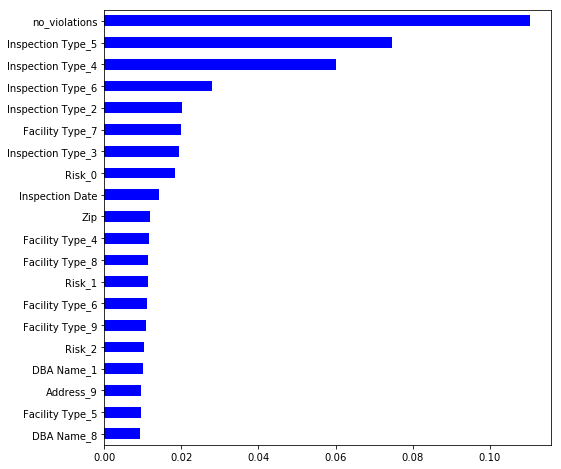

In [11]:
def show_feature_importances(gclf, X, n=20, figsize=(8, 8)):
    
    importances = pd.Series(
        gclf.feature_importances_, 
        X.columns)

    top_n = importances.sort_values(ascending=False)[:n]
    
    plt.figure(figsize=figsize)
    top_n.sort_values().plot.barh(color='blue')

    
clf = XGBClassifier()
booster = xgb.Booster()
booster.load_model('dart_is_op.model')
clf._Booster = booster
clf._le = LabelEncoder().fit(y_val)
clf.predict(X_val)

show_feature_importances(clf, X_train)

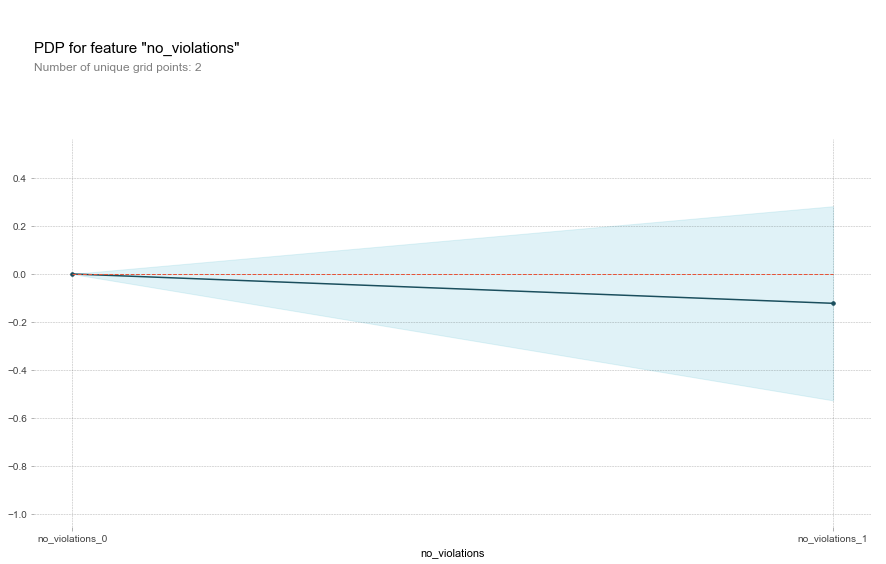

In [12]:
from pdpbox.pdp import pdp_isolate, pdp_plot
feature='no_violations'
pdp_isolated = pdp_isolate(model=clf, dataset=X_train, model_features=X_train.columns, feature=feature)
pdp_plot(pdp_isolated, feature);